In [1]:
# !pip install graphviz

In [2]:
def f(x):
    return 3*x**2 + 2*x + 10

In [3]:
# calculate derivative
def derivative_f(x):
    h = 0.00000001
    return (f(x+h) - f(x))/h
    

In [4]:
# calculate derivative at x=-1/4

derivative_f(-1/4)

0.5000000413701855

In [5]:
# derivative is zero at x=-1/3

derivative_f(x=-1/3)

1.7763568394002505e-07

In [6]:
# implement value object that supports mathematical operations like sum and multiply and back tracks on grad and calculation

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return "Value(data={})".format(self.data)
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
        

In [41]:
a = Value(6.0, label='a')
b = Value(10.0, label='b')
c = Value(4.0, label='c')
e = a*b; e.label = 'e'
d = e + c ;d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

In [8]:
# Display graphical representation of value

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s |data %.4f | grad %.4f  }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

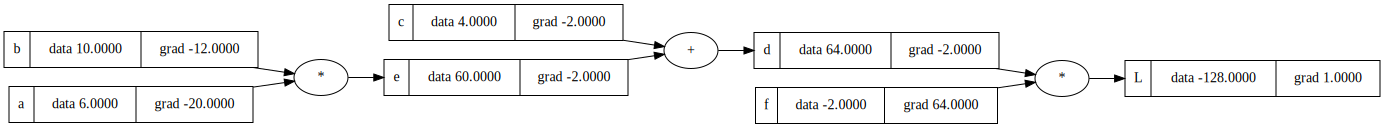

In [64]:
draw_dot(L)

In [62]:
L.grad = 1.0
d.grad = -2.0
f.grad = 64.0
e.grad = -2.0
c.grad = -2.0
a.grad = -2.0 * 10.0
b.grad = -2.0 * 6.0

In [65]:
#calculate grad locally

def lol():
    h = 0.0001
    a = Value(6.0, label='a')
    b = Value(10.0, label='b')
    c = Value(4.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c ;d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(6.0, label='a')
    b = Value(10.0, label='b')
    b.data+=h
    c = Value(4.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c ;d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    
    return (L2-L1)/h

    
lol()    

-11.999999999829924